In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import transform_lib
import decision_lib
from sklearn import cluster, mixture
import validation_lib

np.random.seed(200)

In [2]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    #"po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    #"po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    #"po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()
np_positive_control = df_positive_control.to_numpy()

# generate decorrelation transform
ZCA_whitener = transform_lib.WhitenTransformer(transform_lib.Whitenings.ZCA_COR)

# get the axis-disease correspondence
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']

# fix clustering algorithm
cluster_engine = cluster.KMeans(n_clusters=256)
#cluster_engine = mixture.BayesianGaussianMixture(n_components=64)
#cluster_engine = cluster.DBSCAN(eps=0.1, n_jobs=8)


In [4]:

# Define classifier
zca_decitions = decision_lib.ThresholdMeanClassifier(
                                     negative_control=np_negative_control,
                                     positive_control=np_positive_control,
                                     cluster_algorithm=cluster_engine,
                                     transform_base="pos",
                                     whitening_transformer=ZCA_whitener,
                                     prediction_axis=prediction_axis,
                                     )
# train classifier and predict labels
zca_decitions.fit(np_di)
df_zca_preds = zca_decitions.predict(np_di)

/home/nico/.cache/pypoetry/virtualenvs/ds-lab-4Qf2VVQw-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/nico/.cache/pypoetry/virtualenvs/ds-lab-4Qf2VVQw-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0, n_outlier: 0

Total error rate: 0.0006805929104329366
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.001518     0.001622   0.000326   0.000477   0.000052 0.000088

False negative rate: 0.0006590004957618408
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.001513     0.001586   0.000295   0.000461   0.000052 0.000047

True negative rate: 0.9568695835427797
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.960818     0.956392   0.942825   0.944577   0.965751 0.970855

Precision (TP / (TP + FP)): 0.9994916012526945
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999862     0.999137   0.999453   0.999717        1.0 0.998575

Recall (TP / (TP + FN)): 0.9847130950472832
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.961376     0.963606   0.994831   0.991676   0.998487 0.998397

Accuracy ((TP + TN) / (P + N)): 0.9586457630797937
 SARS-N2_POS  SARS

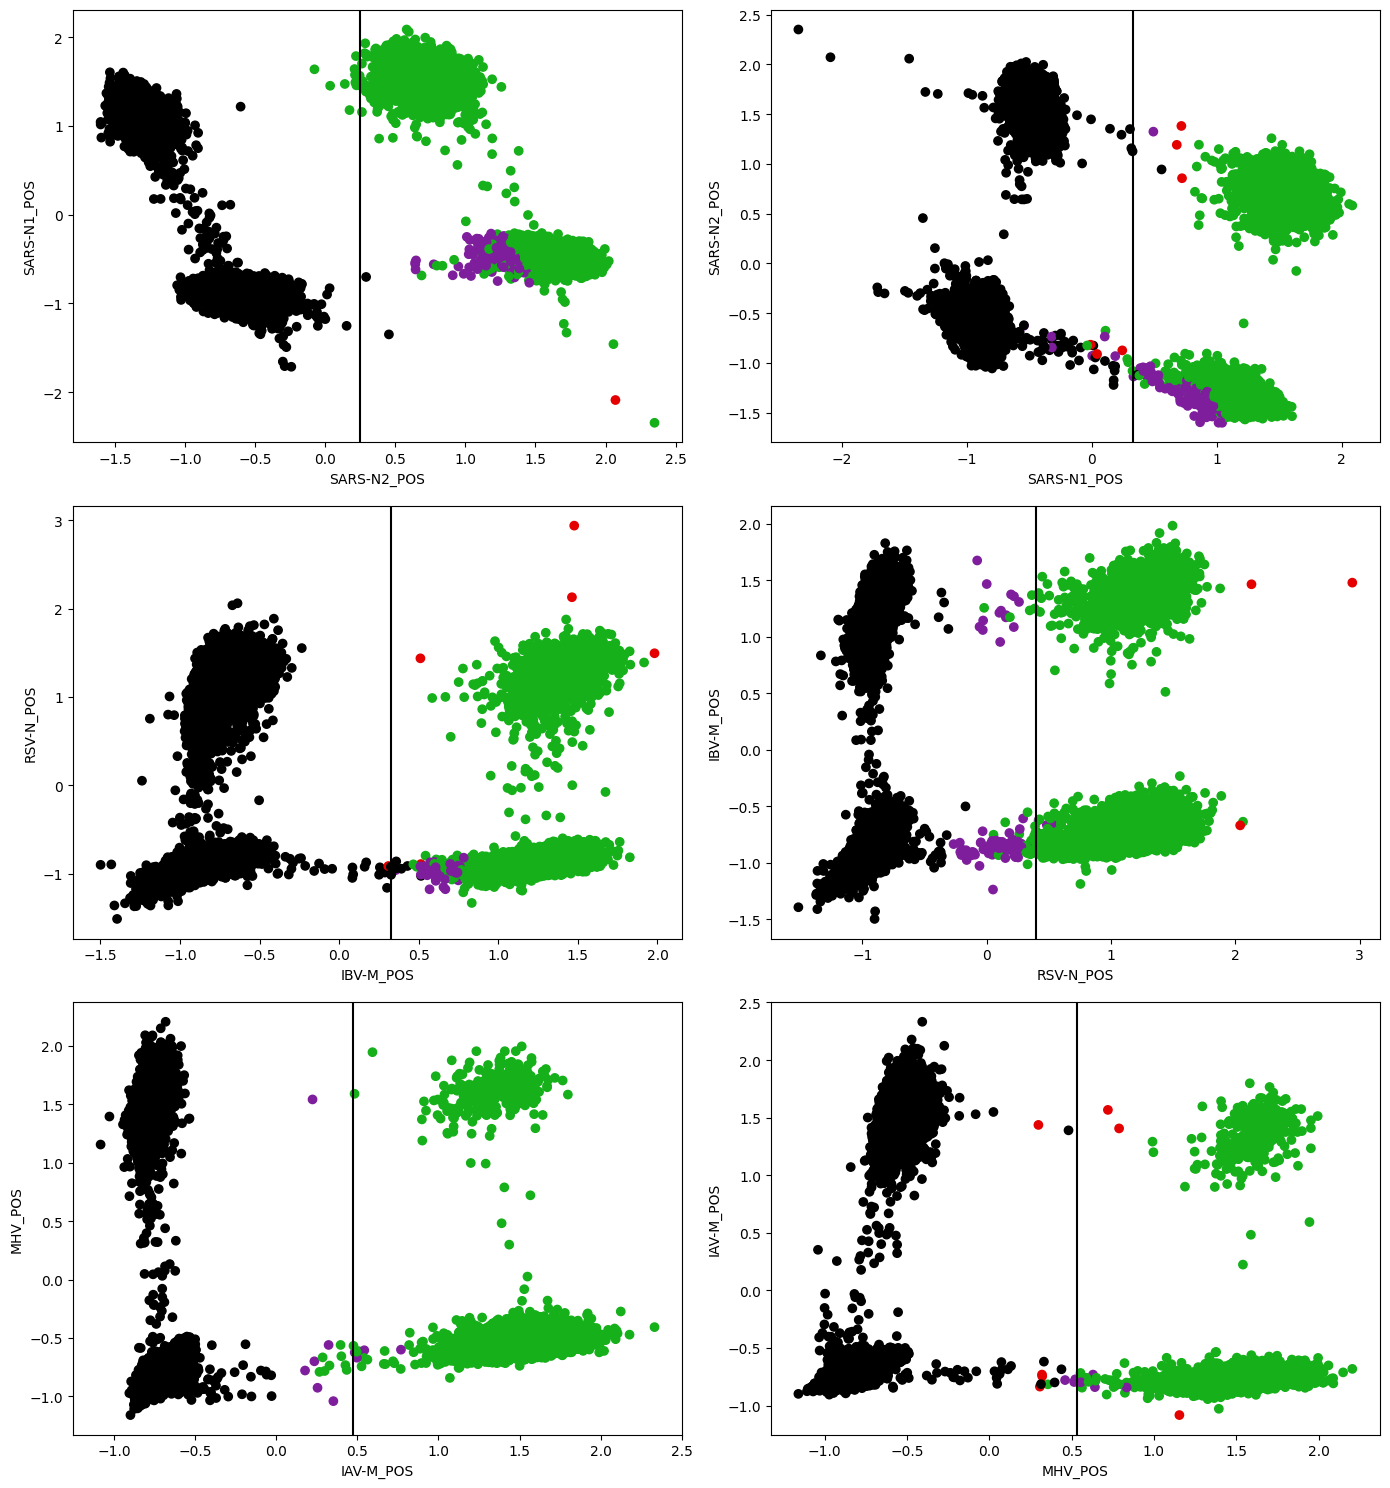

In [5]:

df_data_points = pd.DataFrame(data=zca_decitions.X_all_transformed, columns=prediction_axis)
df_predictions = df_zca_preds
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
axis_thres = pd.DataFrame(data=zca_decitions.axis_threshholds.reshape(1,-1), columns=prediction_axis)

validation_lib.validate_labels(df_ground_trouth, df_predictions)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        axis_thresh=axis_thres,
        n_cols=2,
        )

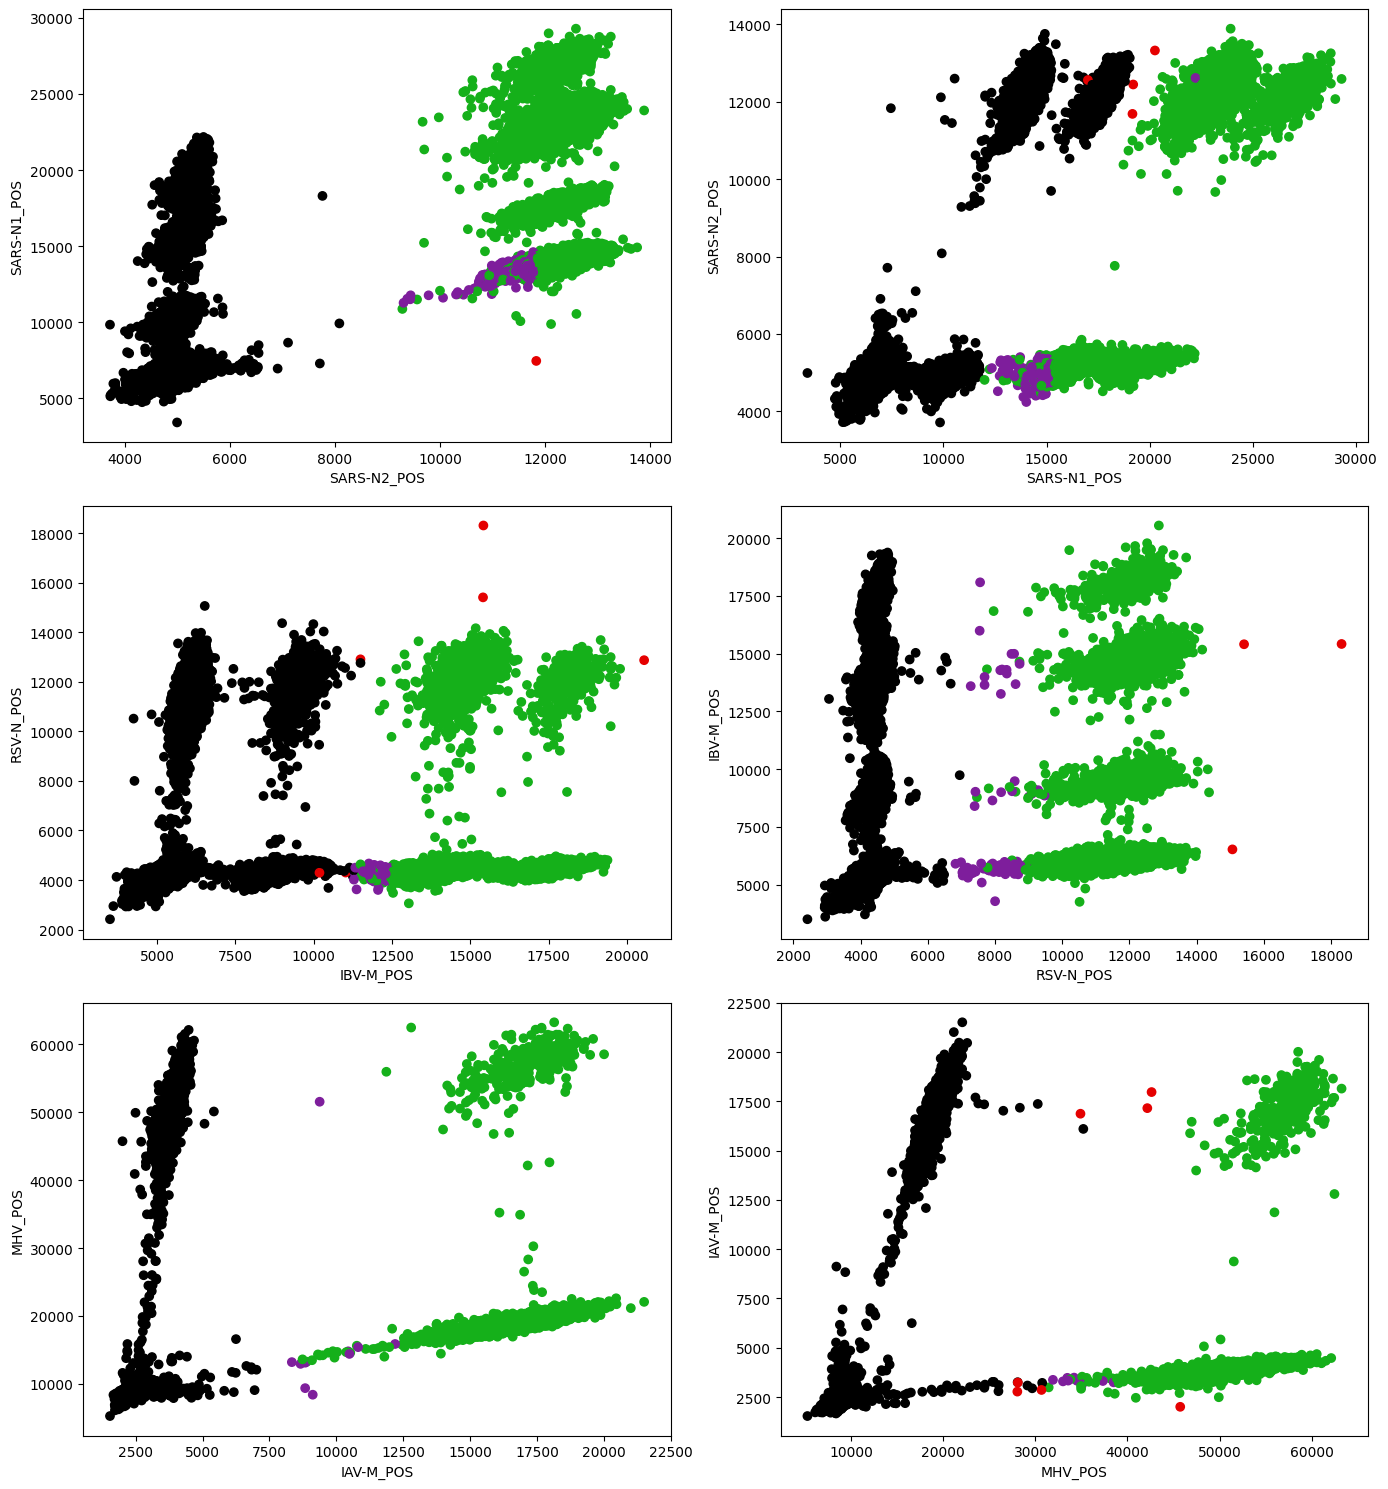

In [6]:

df_data_points = pd.DataFrame(data=zca_decitions.X, columns=prediction_axis)
df_predictions = df_zca_preds
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
# axis_thres = pd.DataFrame(data=zca_decitions.axis_threshholds.reshape(1,-1), columns=prediction_axis)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        axis_thresh=None,
        n_cols=2,
        )